[View in Colaboratory](https://colab.research.google.com/github/aseria/mlcc/blob/test/intro_to_sparse_data_and_embeddings.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 희소 데이터 및 임베딩 소개

**학습 목표:**
* 영화 리뷰 문자열 데이터를 희소 특성 벡터로 변환한다
* 희소 특성 벡터를 사용하여 감정 분석 선형 모델을 구현한다
* 데이터를 두 차원으로 투영하는 임베딩을 사용하여 감정 분석 DNN 모델을 구현한다
* 임베딩을 시각화하여 단어 간의 관계에 대해 모델이 학습한 내용을 확인한다

이 실습에서는 희소 데이터에 대해 알아보고 [ACL 2011 IMDB 데이터 세트](http://ai.stanford.edu/~amaas/data/sentiment/)에서 가져온 영화 리뷰 텍스트 데이터로 임베딩을 사용해 봅니다. 이 데이터는 이미 `tf.Example` 형식으로 처리되어 있습니다.  

 ## 설정

우선 필요한 모듈을 import로 불러오고 학습 및 테스트 데이터를 다운로드합니다. [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras)에 포함된 파일 다운로드 및 캐싱 도구를 사용하여 데이터 세트를 검색할 수 있습니다.

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

40697856/40688441 [==============================] - 0s 0us/step


In [9]:
### YOUR CODE HERE
train_path  # 다운로드 패스

'/content/.keras/datasets/train.tfrecord'

 ## 감정 분석 모델 만들기

 이 데이터로 감정 분석 모델을 학습시켜 리뷰가 전반적으로 *긍정적*(라벨 1)인지 아니면 *부정적*(라벨 0)인지를 예측해 보겠습니다.

이렇게 하려면 문자열 값인 `단어`를 *어휘*, 즉 데이터에 나올 것으로 예상되는 각 단어의 목록을 사용하여 특성 벡터로 변환합니다. 이 실습을 진행하기 위해 제한된 단어 집합을 갖는 소규모 어휘를 만들었습니다. 이러한 단어는 대부분 *긍정* 또는 *부정*을 강하게 암시하는 것이 밝혀졌지만 일부분은 단순히 흥미를 위해 추가되었습니다.

어휘의 각 단어는 특성 벡터의 좌표에 매핑됩니다. 예의 문자열 값인 `단어`를 이 특성 벡터로 변환하기 위해, 예 문자열에 어휘 단어가 나오지 않으면 각 좌표의 값에 0을 입력하고 어휘 단어가 나오면 1을 입력하도록 인코딩하겠습니다. 예의 단어 중 어휘에 나오지 않는 단어는 무시됩니다.

 **참고:** *물론 더 큰 어휘를 사용할 수도 있으며 이러한 어휘를 만드는 데 특화된 도구들이 있습니다. 뿐만 아니라 어휘에 나오지 않는 단어를 단순히 무시하지 않고 적은 수의 OOV(out-of-vocabulary) 버킷을 도입하여 해당 단어를 해시할 수 있습니다. 명시적인 어휘를 만드는 대신 각 단어를 해시하는 __특성 해싱__ 접근법을 사용할 수도 있습니다. 이 방법은 실무에는 적합하지만 해석 가능성이 사라지므로 실습 목적으로는 유용하지 않습니다. 이와 관련된 도구에 대해서는 tf.feature_column 모듈을 참조하세요.*

 ## 입력 파이프라인 구축

 우선 텐서플로우 모델로 데이터를 가져오는 입력 파이프라인을 구성하겠습니다. 다음 함수를 사용하여 [TFRecord](https://www.tensorflow.org/programmers_guide/datasets) 형식인 입력 및 테스트 데이터를 파싱하고 특성과 해당 라벨로 이루어진 dict를 반환할 수 있습니다.

In [0]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

 함수가 정상적으로 작동하는지 확인하기 위해 학습 데이터에 대한 `TFRecordDataset`를 생성하고 위 함수를 사용하여 데이터를 특성 및 라벨에 매핑합니다.

In [3]:
# Create the Dataset object
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

 다음 셀을 실행하여 학습 데이터 세트에서 첫 예를 확인합니다.

In [4]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()

sess.run(n)

({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

 이제 텐서플로우 에스티메이터 개체의 `train()` 메소드에 전달할 수 있는 정식 입력 함수를 만들겠습니다.

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

 ## 작업 1: 희소 입력 및 명시적 어휘와 함께 선형 모델 사용

첫 번째 모델로서 54개의 정보 단어를 사용하여 [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) 모델을 만들겠습니다. 처음에는 단순하게 시작하는 것이 좋습니다.

다음 코드는 단어에 대한 특성 열을 만듭니다. [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) 함수는 문자열과 특성 벡터 간의 매핑을 포함하는 특성 열을 만듭니다.

In [0]:
# 54 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family", "man", "woman", "boy", "girl")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

 다음으로, `LinearClassifier`를 생성하고 학습 세트로 학습시킨 후 평가 세트로 평가합니다. 코드를 잘 읽어보고 실행하여 결과를 확인해 보세요.

In [8]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.344691
accuracy_baseline 0.5
global_step 1000
recall 0.78736
auc 0.871949
prediction/mean 0.4734944
precision 0.7883691
label/mean 0.5
average_loss 0.45378765
auc_precision_recall 0.86505127
accuracy 0.788
---
Test set metrics:
loss 11.403583
accuracy_baseline 0.5
global_step 1000
recall 0.78136
auc 0.86921066
prediction/mean 0.47286868
precision 0.7839942
label/mean 0.5
average_loss 0.45614332
auc_precision_recall 0.86152333
accuracy 0.78304
---


 ## 작업 2: 심층신경망(DNN) 모델 사용

위 모델은 선형 모델입니다. 비교적 좋은 성능을 발휘하지만, DNN 모델로 성능을 더 높일 수 있을까요?

`LinearClassifier`를 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)로 교체해 보겠습니다. 다음 셀을 실행하고 결과를 확인해 보세요.

In [36]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
loss 18.140491
accuracy_baseline 0.52
global_step 1000
recall 1.0
auc 0.73717946
prediction/mean 0.69491035
precision 0.68421054
label/mean 0.52
average_loss 0.7256197
auc_precision_recall 0.6922219
accuracy 0.76
---
Test set metrics:
loss 7.7074943
accuracy_baseline 0.6
global_step 1000
recall 1.0
auc 0.99999994
prediction/mean 0.5473587
precision 0.6666667
label/mean 0.4
average_loss 0.30829978
auc_precision_recall 0.9999999
accuracy 0.8
---


 ## 작업 3: DNN 모델에 임베딩 사용

이 작업에서는 임베딩 열을 사용하여 DNN 모델을 구현합니다. 임베딩 열은 희소 데이터를 입력으로 취하고 저차원 밀집 벡터를 출력으로 반환합니다.

 **참고:** *희소 데이터로 모델을 학습시킬 때 embedding_column은 일반적으로 연산 효율이 가장 높은 옵션입니다. 이 실습 끝부분의 [선택 섹션](#scrollTo=XDMlGgRfKSVz)에서 `embedding_column`과 `indicator_column`의 구현상 차이점 및 상대적인 장단점을 자세히 알아봅니다.*

 아래 코드에서 다음을 수행합니다.

* 데이터를 2개의 차원으로 투영하는 `embedding_column`을 사용하여 모델의 특성 열을 정의합니다. `embedding_column`의 함수 시그니처에 대한 자세한 내용은 [TF 문서](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)를 참조하세요.
* 다음과 같은 사양으로 `DNNClassifier`를 정의합니다.
  * 각각 20개 유닛을 포함하는 히든 레이어 2개
  * Adagrad 최적화, 학습률 0.1
  * `gradient_clip_norm`을 5.0으로 지정

 **참고:** *실무에서는 2보다 높은 50 또는 100차원으로 투영하게 됩니다. 그러나 여기에서는 시각화하기 쉽도록 2차원만 사용합니다.*

 ### 힌트

In [0]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

 ### 아래 코드 완성하기

In [54]:
########################## YOUR CODE HERE ######################################
# Define the embedding column
terms_embedding_column = tf.feature_column.embedding_column(categorical_column=terms_feature_column,
                                                           dimension=2)

# Define the feature columns
feature_columns = [terms_embedding_column] 

# Define the DNNClassifier
my_optimizer= tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=feature_columns, #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)        

################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.312484
accuracy_baseline 0.5
global_step 1000
recall 0.82704
auc 0.86920875
prediction/mean 0.51262623
precision 0.76560766
label/mean 0.5
average_loss 0.45249933
auc_precision_recall 0.8586288
accuracy 0.78692
---
Test set metrics:
loss 11.373603
accuracy_baseline 0.5
global_step 1000
recall 0.81936
auc 0.86751807
prediction/mean 0.51181555
precision 0.7632461
label/mean 0.5
average_loss 0.4549441
auc_precision_recall 0.85619324
accuracy 0.7826
---


In [53]:
feature_columns

[_EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family', 'man', 'woman', 'boy', 'girl'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function _creator at 0x7f10ce933b90>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)]

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [40]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.337837
accuracy_baseline 0.5
global_step 1000
recall 0.82032
auc 0.8680731
prediction/mean 0.5045907
precision 0.76906925
label/mean 0.5
average_loss 0.45351347
auc_precision_recall 0.85636425
accuracy 0.787
---
Test set metrics:
loss 11.396578
accuracy_baseline 0.5
global_step 1000
recall 0.81264
auc 0.86667573
prediction/mean 0.5039992
precision 0.76519775
label/mean 0.5
average_loss 0.45586312
auc_precision_recall 0.85449517
accuracy 0.78164
---


 ## 작업 4: 임베딩이 실제로 적용되는지 확인

위 모델에서 사용한 `embedding_column`은 제대로 작동하는 것 같지만, 내부적으로는 어떻게 사용되는지 알 수가 없습니다. 모델에서 내부적으로 임베딩을 실제로 사용하는지 확인하려면 어떻게 해야 할까요?

우선 모델의 텐서를 살펴보겠습니다.

In [55]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [56]:
for n in classifier.get_variable_names():
  print(n, classifier.get_variable_value(n).shape)

dnn/hiddenlayer_0/bias (20,)
dnn/hiddenlayer_0/bias/t_0/Adagrad (20,)
dnn/hiddenlayer_0/kernel (2, 20)
dnn/hiddenlayer_0/kernel/t_0/Adagrad (2, 20)
dnn/hiddenlayer_1/bias (20,)
dnn/hiddenlayer_1/bias/t_0/Adagrad (20,)
dnn/hiddenlayer_1/kernel (20, 20)
dnn/hiddenlayer_1/kernel/t_0/Adagrad (20, 20)
dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights (54, 2)
dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad (54, 2)
dnn/logits/bias (1,)
dnn/logits/bias/t_0/Adagrad (1,)
dnn/logits/kernel (20, 1)
dnn/logits/kernel/t_0/Adagrad (20, 1)
global_step ()


# Classifier 구조
결국 이렇게 연결
bias 및 optimzer변수 생략

input(54) --> Embedding Layer(2) --> HiddenLayer_(20)--> HiddenLayer_1(20) --> logits(1)

 이제 `'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`이라는 임베딩 레이어가 있음을 확인할 수 있습니다. 여기에서 흥미로운 점은 이 레이어는 여타 히든 레이어와 마찬가지로 모델의 다른 부분과 함께 동시에 학습된다는 점입니다.

임베딩 레이어가 올바른 형태로 되어 있을까요? 다음 코드를 실행하여 알아보세요.

 **참고:** *여기에서 사용하는 임베딩은 54차원 벡터를 2차원으로 투영하는 행렬입니다.*

In [45]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(54, 2)

 잠시 동안 다양한 레이어와 형태를 직접 확인하여 모든 요소가 예상대로 연결되어 있는지 확인해 보세요.

 ## 작업 5: 임베딩 조사

이제 실제 임베딩 공간을 조사하여 각 단어가 결국 어느 위치에 배치되었는지 확인해 보겠습니다. 다음을 수행하세요.
1. 다음 코드를 실행하여 **작업 3**에서 학습시킨 임베딩을 확인합니다. 결과가 예상과 일치하나요?

2. **작업 3**의 코드를 재실행하여 모델을 다시 학습시킨 후 아래의 임베딩 시각화를 다시 실행합니다. 무엇이 그대로인가요? 무엇이 달라졌나요?

3. 마지막으로 10단계만 사용하여 모델을 다시 학습시킵니다. 이렇게 하면 매우 열악한 모델이 만들어집니다. 아래의 임베딩 시각화를 다시 실행합니다. 이제 결과가 어떠한가요? 이유는 무엇일까요?

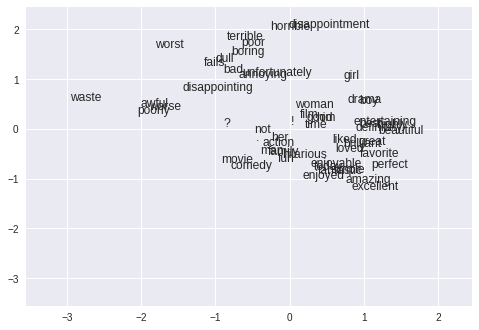

In [65]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0's everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little set-up to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (12, 12)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

 ## 작업 6: 모델 성능 개선 시도

모델을 다듬어 성능을 높일 수 있는지 확인해 보세요. 다음과 같은 방법을 시도해 볼 수 있습니다.

* **초매개변수 변경** 또는 Adam 등의 **다른 옵티마이저 사용**. 이 전략으로 향상되는 정확성은 1~2%에 불과할 수 있습니다.
* **`informative_terms`에 더 많은 단어 추가.** 이 데이터 세트의 30,716개 단어를 모두 포함하는 전체 어휘 파일은 https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/terms.txt 입니다. 이 어휘 파일에서 단어를 더 추출할 수도 있고, `categorical_column_with_vocabulary_file` 특성 열을 통해 전체 어휘를 사용할 수도 있습니다.

In [66]:
# Download the vocabulary file.
terms_url = 'https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

262144/253538 [===============================] - 0s 0us/step


In [67]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 17.320736
accuracy_baseline 0.5
global_step 1000
recall 0.00784
auc 0.5293025
prediction/mean 0.49557933
precision 0.7205882
label/mean 0.5
average_loss 0.69282943
auc_precision_recall 0.58454853
accuracy 0.5024
---
Test set metrics:
loss 17.320316
accuracy_baseline 0.5
global_step 1000
recall 0.00816
auc 0.5341601
prediction/mean 0.4955957
precision 0.7183099
label/mean 0.5
average_loss 0.6928127
auc_precision_recall 0.5947034
accuracy 0.50248
---


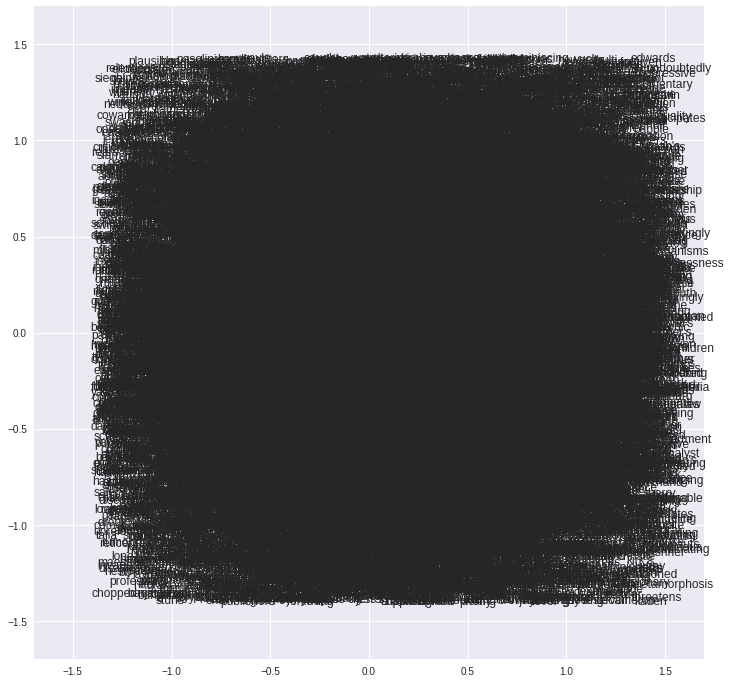

In [68]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0's everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little set-up to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (12, 12)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

 ## 맺음말

임베딩을 사용한 DNN 솔루션이 원래의 선형 모델보다 우수할 수 있지만, 선형 모델도 성능이 그다지 나쁘지 않았으며 학습 속도는 상당히 더 빨랐습니다. 선형 모델의 학습 속도가 더 빠른 이유는 업데이트할 매개변수 또는 역전파할 레이어의 수가 더 적기 때문입니다.

응용 분야에 따라서는 선형 모델의 빠른 속도가 큰 장점이 될 수 있고, 선형 모델도 품질 면에서 충분하고도 남을 수 있습니다. 다른 분야에서는 DNN이 제공하는 추가적인 모델 복잡성과 용량이 더 중요할 수 있습니다. 모델 아키텍처를 정의할 때는 어떠한 모델이 적합한지 판단할 수 있도록 문제를 충분히 탐구해야 합니다.

 ### *선택 토의:* `embedding_column`과 `indicator_column`의 상대적인 장단점

개념적으로, `LinearClassifier` 또는 `DNNClassifier`를 학습시킬 때 희소 열을 사용하려면 어댑터가 필요합니다. TF는 `embedding_column` 또는 `indicator_column`이라는 두 가지 옵션을 제공합니다.

**작업 1**과 같이 LinearClassifier를 학습시킬 때는 내부적으로 `embedding_column`이 사용됩니다. **작업 2**에서 확인한 바와 같이 `DNNClassifier`를 학습시킬 때는 `embedding_column` 또는 `indicator_column` 중 하나를 명시적으로 선택해야 합니다. 이 섹션에서는 간단한 예를 살펴보면서 둘 사이의 차이점 및 상대적인 장단점에 대해 설명합니다.

 `"great"`, `"beautiful"`, `"excellent"` 값을 포함하는 희소 데이터가 있다고 가정해 보겠습니다. 여기에서 사용하는 어휘 크기는 $V = 54$이므로 첫 번째 레이어의 각 유닛(뉴런)은 54개의 가중치를 갖습니다. 희소 입력의 단어 수는 $s$로 나타냅니다. 따라서 이 희소 데이터 예에서 $s = 3$입니다. 가능한 값이 $V$개인 입력 레이어에 대해 $d$개 유닛을 갖는 히든 레이어가 계산해야 하는 벡터 행렬 곱셈은 $(1 \times V) * (V \times d)$입니다. 연산 비용은 $O(V * d)$입니다. 이 비용은 해당 히든 레이어의 가중치 수에 비례하며 $s$와는 무관합니다.

[`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)을 사용하여 입력에 원-핫 인코딩(길이가 $V$이고 존재하는 단어에 대해 1, 그렇지 않은 단어에 대해 0을 포함하는 부울 벡터)을 적용하면 곱셈과 덧셈의 많은 항에 0이 들어갑니다.

 크기가 $d$인 [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)을 사용해도 정확히 같은 결과를 얻을 수 있으며, 다음과 같이 입력 예인 `"great"`, `"beautiful"`, `"excellent"`에 있는 3개 특성에 대한 임베딩만 조회하여 합산합니다. $(1 \times d) + (1 \times d) + (1 \times d)$. 존재하지 않는 특성에 대한 가중치는 벡터 행렬 곱셈에서 0이 곱해지므로 결과에 전혀 기여하지 않습니다. 존재하는 특성에 대한 가중치는 벡터 행렬 곱셈에서 1이 곱해집니다. 따라서 임베딩 조회를 통해 획득한 가중치를 더한 결과는 벡터 행렬 곱셈의 결과와 동일합니다.

임베딩을 사용할 때 임베딩 조회에 필요한 연산 비용은 $O(s * d)$로서, $s$가 $V$보다 훨씬 작은 경우 희소 데이터의 `indicator_column`에 대한 비용인 $O(V * d)$보다 훨씬 더 효율적입니다. 이러한 임베딩은 학습 중인 대상이므로 어떠한 학습 반복에서도 지금 조회 중인 현재 가중치가 됩니다.

 **작업 3**에서 확인한 것처럼, `DNNClassifier`를 학습시킬 때 `embedding_column`을 사용하면 모델에서 특성의 저차원 표현을 학습하는데, 이때 유사성 측정항목은 특성 벡터 간의 내적값으로 정의합니다. 이 예에서는 영화 리뷰라는 맥락에서 비슷하게 사용된 `"great"`, `"excellent"` 등의 단어는 임베딩 공간에서 서로 가까이 위치하므로 내적값이 크고, `"great"`와 `"bad"` 같이 상이한 단어는 임베딩 공간에서 멀리 떨어져 있으므로 내적값이 작습니다.

내적 자료 
http://mrw0119.tistory.com/12
